# Lab 2

This second practical session will allow you to work with the imputation methods presented in Session 2, namely:
* mean imputation,
* k-nearest neighbors imputation,
* iterative imputation.

The first exercise is more theoretical and helps develop an intuition for how the methods work. Exercises 2 and 3 are more practical.

**Note** : Imputation can have different objectives. Here, you will study methods aimed at minimizing imputation error by always choosing the most probable values. This is a perfectly valid goal, but these methods have the drawback of distorting the data distribution, notably by reducing the variance. Therefore, they are not suitable when the goal is to estimate the distribution.

# Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Libraries imported in the solution

In [ ]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.datasets import load_breast_cancer

import warnings

# Exercise 1: Basic applications of imputation methods

In this exercise, you will use synthetic two-dimensional data to facilitate visualization of the results.

## Question 1 : Bivariate Gaussian sample

Generate a bivariate sample (*i.e.* with $d=2$ variables), Gaussian,

$$
\left( X_{i.} \right)_{1\leq i\leq n}
=\left( X_{i0}, X_{i1} \right)_{1\leq i\leq n}
$$

of size $n=500$, with mean $\mu$ and covariance matrix $\Sigma$:

$$
\mu = \begin{bmatrix}
  \mu_0 \\[6pt] \mu_1
\end{bmatrix}, \quad
\Sigma = \begin{bmatrix}
  \sigma_0^2 & \rho \sigma_0 \sigma_1 \\[6pt]
  \rho \sigma_0 \sigma_1 & \sigma_1^2
\end{bmatrix},
$$

with the following values :
$$
\mu_0 = 0,~\mu_1 = 0,~\sigma_0 = 1,~\sigma_1 = 0.7,~\rho = 0.8
$$

You will save the sample in a variable `xfull`.

Plot the sample using a scatter plot.

### Solution

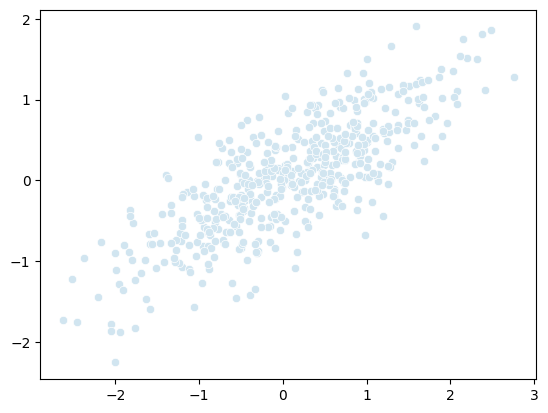

In [ ]:
np.random.seed(0)

n = 500
d = 2
mu0 = 0.
mu1 = 0.
sig0 = 1.
sig1 = 0.7
rho = 0.8

mean = np.array([mu0, mu1])
cov = np.array([
    [sig0 ** 2, rho * sig0 * sig1],
    [rho * sig0 * sig1, sig1 ** 2]
    ])

xfull = np.random.multivariate_normal(mean, cov, size=n)

ax = sns.scatterplot(x=xfull[:, 0], y=xfull[:, 1], color=['#d1e5f0'])

## Question 2 : generation of missing values

### Question 2a

Run the following cell to generate missing values as in Notbeook 1, and obtain the amputed dataset, `xmiss`. What is the missing data mechanism here? What does the variable `p` represent? How many possible patterns are there, i.e., possible NA scenarios for a row?

In [ ]:
p = 0.4

xmiss = np.copy(xfull)
for j in range(d):
  miss_id = (np.random.uniform(0, 1, size=n) < p)
  xmiss[miss_id, j] = np.nan

display(pd.DataFrame(xmiss).head(10))

,0,1
0,-1.808212,-0.992121
1,-1.396623,0.060928
2,-1.641335,-1.474575
3,-0.902385,NaN
4,0.021234,0.189484
5,-0.424653,0.349494
6,-0.770159,-0.443447
7,NaN,NaN
8,NaN,NaN
9,NaN,-0.456226


### Solution

The mechanism is MCAR because the missingness `miss_id` is independent of `xfull`.

`p` represents the probability that each variable is missing (note that we could choose a different `p_j` for each variable and still have MCAR).

There are 4 possible patterns :

* Both $X_0,~X_1$ are observed,
* Only $X_0$ is missing,
* Only $X_1$ is missing,
* Both $X_0,~X_1$ are missing.

### Question 2b

Run the following cell to visualize `xmiss`. Interpret the plot: what does each group of points represent?

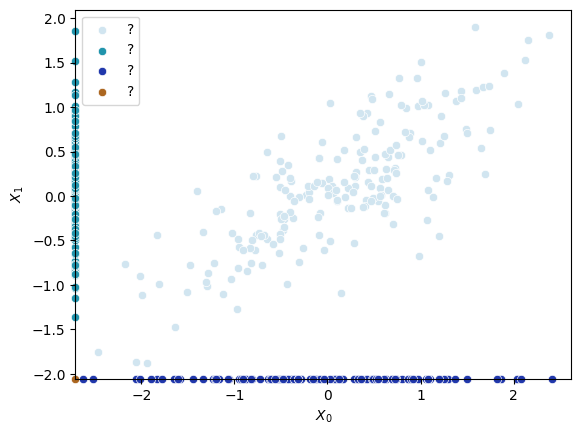

In [ ]:
where_full = ~np.isnan(xmiss[:, 0]) & ~np.isnan(xmiss[:, 1])
where_na0 = np.isnan(xmiss[:, 0]) & ~np.isnan(xmiss[:, 1])
where_na1 = np.isnan(xmiss[:, 1]) & ~np.isnan(xmiss[:, 0])
where_na01 = np.isnan(xmiss[:, 0]) & np.isnan(xmiss[:, 1])

ax = sns.scatterplot(x=xmiss[where_full, 0], y=xmiss[where_full, 1], color=['#d1e5f0'], label="?")

(xmin, xmax), (ymin, ymax) = ax.get_xlim(), ax.get_ylim()

_ = sns.scatterplot(x=xmin, y=xmiss[where_na0, 1], color=['#2194ac'], ax=ax, clip_on=False, label="?")
_ = sns.scatterplot(x=xmiss[where_na1, 0], y=ymin, color=['#2138ac'], ax=ax, clip_on=False, label="?")
_ = sns.scatterplot(x=[xmin], y=[ymin], color=['#ac6721'], ax=ax, clip_on=False, label="?")

_ = ax.set_xlim(xmin, xmax)
_ = ax.set_ylim(ymin, ymax)

_ = ax.set_xlabel(r'$X_0$')
_ = ax.set_ylabel(r'$X_1$')

ax.legend();

### Solution

In the first group, both variables $X_{.0}$ et $X_{.1}$are observed, so the points are displayed normally.

In the second group, variable $X_{.0}$ is missing, and we only have access to $X_{.1}$. In this case, the points are displayed along the vertical axis, since we cannot place them horizontally.

Conversely, in the third group, variable is missing, so the points are displayed along the horizontal axis, as we cannot place them vertically.

Finally, the points in the last group, for which both variables are missing, are displayed in the bottom-left corner.

These four cases correspond to the four possible *patterns*.

## Question 3 : mean imputation

The simplest possible imputation is mean imputation. Using the `sklearn.impute` module, replace the missing values in `xmiss` with the mean of each variable, and visualize the imputed dataset by replicating the type of plot used in Question 2b.

### Solution

In [ ]:
mean_imputer = SimpleImputer(missing_values=np.nan, strategy="mean")
ximp_mean = mean_imputer.fit_transform(xmiss)

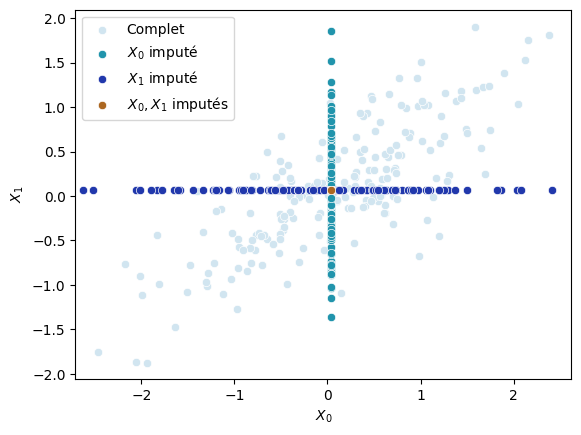

In [ ]:
ax = sns.scatterplot(x=xmiss[where_full, 0], y=xmiss[where_full, 1], color=['#d1e5f0'], label="Complete")

(xmin, xmax), (ymin, ymax) = ax.get_xlim(), ax.get_ylim()

_ = sns.scatterplot(x=ximp_mean[where_na0, 0], y=ximp_mean[where_na0, 1], color=['#2194ac'], ax=ax, clip_on=False, label=r"$X_0$ imputed")
_ = sns.scatterplot(x=ximp_mean[where_na1, 0], y=ximp_mean[where_na1, 1], color=['#2138ac'], ax=ax, clip_on=False, label=r"$X_1$ imputed")
_ = sns.scatterplot(x=ximp_mean[where_na01, 0], y=ximp_mean[where_na01, 1], color=['#ac6721'], ax=ax, clip_on=False, label=r"$X_0,X_1$ imputed")

ax.set_xlim(xmin, xmax);
ax.set_ylim(ymin, ymax);

_ = ax.set_xlabel(r'$X_0$')
_ = ax.set_ylabel(r'$X_1$')

ax.legend();

## Question 4: Minimization of the theoretical imputation error (difficult question requiring knowledge of conditional expectation)

For a value $X_{i.} = \left( X_{i0}, X_{i1} \right)$ of the sample (the real data), we define its squared imputation error $E_i$ as follows:

$$
E_i
= \lVert X_{i.} - \hat X_{i.} \rVert^2
= \left(X_{i0} - \hat X_{i0} \right)^2
  + \left(X_{i1} - \hat X_{i1} \right)^2
$$

where $\hat X_{i.}$ is the imputed value.

The mean squared imputation error $E$ on the sample is given by:

$$E = \frac{1}{n} \sum_{i=1}^{n} E_i$$

### Question 4a

Compute the mean squared error of the mean imputation from Question 3.

### Solution

In [ ]:
def mse(x_imp, x_true):
  n = len(x_true)
  return (1 / n) * np.sum((x_imp - x_true) ** 2)

In [ ]:
print(mse(ximp_mean, xfull))

0.5681994027699139


### Question 4b

In this bivariate case, how does the error $E_i$ simplify depending on the pattern at row $i$, that is, depending on which variables are missing?

### Solution

$$
\begin{align*}
E_i = \left\{
\begin{array}{ll}
0 & \textrm{if all is observed} \\
\left(X_{i0} - \hat X_{i0} \right)^2 & \textrm{si }X_{i, 0}\textrm{ only missing} \\
\left(X_{i1} - \hat X_{i1} \right)^2 & \textrm{si }X_{i1}\textrm{ only missing} \\
\left(X_{i0} - \hat X_{i0} \right)^2 + \left(X_{i1} - \hat X_{i1} \right)^2 & \textrm{si }X_{i0}, X_{i1}\textrm{ missing}
\end{array}
\right.
\end{align*}
$$

### Question 4c

Suppose we want to minimize the mean squared imputation error.

In this Gaussian model, to which well-known problem does each pattern reduce? What is the optimal imputation in each pattern? Express it in terms of $\mu_0$, $\mu_1$, $\sigma_0$, $\sigma_1$, $\rho$.

### Solution

This least squares minimization problem in each pattern has a known solution, which is the conditional expectation.

When $X_{.1}$ is the only missing variable:
$$
\mathbb{E}[X_{.1} \mid X_{.0} = x_{.0}] = \mu_1 + \rho \frac{\sigma_1}{\sigma_0} (x_{.0} - \mu_0)
$$
When $X_{.0}$ is the only missing variable:
$$
\mathbb{E}[X_{.0} \mid X_{.1} = x_{.1}] = \mu_0 + \rho \frac{\sigma_0}{\sigma_1} (x_{.1} - \mu_1)
$$
When $X_{.0}$ and $X_{.1}$ are both missing
$$
\mathbb{E}[X_{.0}, X_{.1}] = \left(\mu_0,~\mu_1\right).
$$

### Question 4d

Implémentez cette imputation dans une fonction. Calculez son erreur quadratique.

### Correction

In [ ]:
def conditional_expectation_imputation(xmiss, mu0, mu1, sig0, sig1, rho):
    mask = np.isnan(xmiss)
    # get integer patterns from the 2D boolean mask
    # (0,0) -> 0; (1,0) -> 1; (0,1) -> 2; (1,1) -> 3
    patterns = mask[:, 0].astype(int) + 2 * mask[:, 1].astype(int)  # shape: (N,)

    impx0 = np.c_[mu0 + rho * sig0 / sig1 * (xmiss[:, 1] - mu1), xmiss[:, 1]]
    impx1 = np.c_[xmiss[:, 0], mu1 + rho * sig1 / sig0 * (xmiss[:, 0] - mu0)]
    impx01 = np.c_[np.full_like(xmiss[:, 0], mu0), np.full_like(xmiss[:, 1], mu1)]

    # stack impputation cases into shape (4, N, 2)
    imputations = np.stack([xmiss, impx0, impx1, impx01], axis=0)  # shape: (4, N, 2)

    # select appropriate rows from each imputation case using the patterns
    rows = np.arange(len(patterns))  # shape: (500,)

    imp = imputations[patterns, rows]  # shape: (500, 2)

    return imp

In [ ]:
ximp_ce = conditional_expectation_imputation(xmiss, mu0, mu1, sig0, sig1, rho)
print(mse(ximp_ce, xfull))

0.3767953904930494


### Question 4e

Still using the plot from question 2b as inspiration, represent the imputation by the conditional expectation.

### Solution

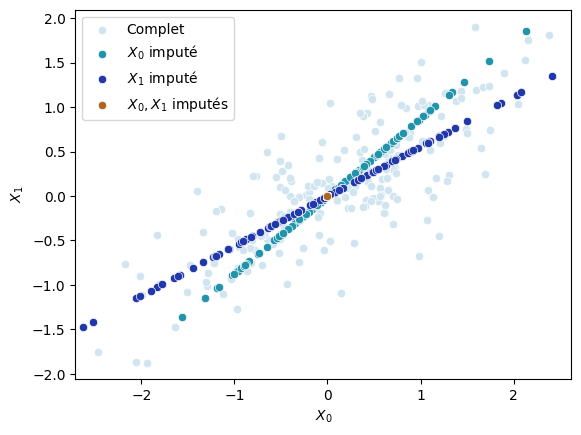

In [ ]:
ax = sns.scatterplot(x=xmiss[where_full, 0], y=xmiss[where_full, 1], color=['#d1e5f0'], label="Complete")

(xmin, xmax), (ymin, ymax) = ax.get_xlim(), ax.get_ylim()

_ = sns.scatterplot(
    x=ximp_ce[where_na0, 0], y=ximp_ce[where_na0, 1],
    color=['#2194ac'], ax=ax, clip_on=False, label=r"$X_0$ imputed")
_ = sns.scatterplot(
    x=ximp_ce[where_na1, 0], y=ximp_ce[where_na1, 1],
    color=['#2138ac'], ax=ax, clip_on=False, label=r"$X_1$ imputed")
_ = sns.scatterplot(
    x=ximp_ce[where_na01, 0], y=ximp_ce[where_na01, 1],
    color=['#ac6721'], ax=ax, clip_on=False, label=r"$X_0,X_1$ imputed")

ax.set_xlim(xmin, xmax);
ax.set_ylim(ymin, ymax);

_ = ax.set_xlabel(r'$X_0$')
_ = ax.set_ylabel(r'$X_1$')

ax.legend();

**Note**: The purpose of this theoretical question was, in addition to working with the concept of patterns, to show that even in a Gaussian case, the ideal imputation is not simply to reduce everything to a single regression line. There is an expression for each pattern!

## Question 5 : Iterative imputation with linear regressions

In practice, of course, we do not know $\mu$ and $\Sigma$, and we don’t even know if the data are Gaussian. Therefore, it is necessary to perform linear regressions to estimate the distribution parameters. This can be done iteratively using the `IterativeImputer` class from the `sklearn.impute` module, using a linear regression as the base estimator. Implement this imputation, represent it in the same way as before, and also calculate its Mean Squared Error (MSE).

### Solution

In [ ]:
imputer = IterativeImputer(estimator=LinearRegression())
ximp_lr = imputer.fit_transform(xmiss)

In [ ]:
print(mse(ximp_lr, xfull))

0.3782322428769079


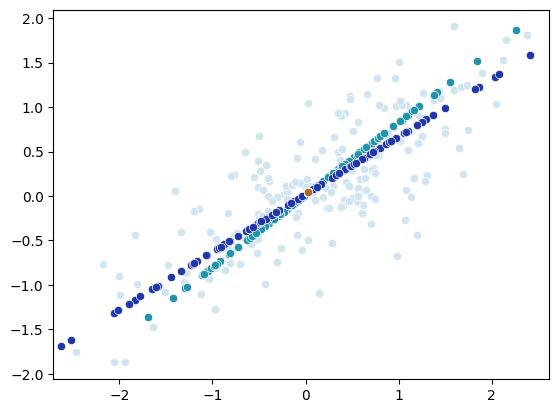

In [ ]:
ax = sns.scatterplot(x=xmiss[where_full, 0], y=xmiss[where_full, 1], color=['#d1e5f0'])

(xmin, xmax), (ymin, ymax) = ax.get_xlim(), ax.get_ylim()

_ = sns.scatterplot(x=ximp_lr[where_na0, 0], y=ximp_lr[where_na0, 1], color=['#2194ac'], ax=ax, clip_on=False)
_ = sns.scatterplot(x=ximp_lr[where_na1, 0], y=ximp_lr[where_na1, 1], color=['#2138ac'], ax=ax, clip_on=False)
_ = sns.scatterplot(x=ximp_lr[where_na01, 0], y=ximp_lr[where_na01, 1], color=['#ac6721'], ax=ax, clip_on=False)

ax.set_xlim(xmin, xmax);
ax.set_ylim(ymin, ymax);

## Question 6 : nearest neighbours

The Gaussian linear model does not always fit the data we study in practice. In the general case, non-parametric methods are more flexible. An essential example of non-parametric imputation is k-nearest neighbors imputation.

Implement this imputation using `sklearn.impute`, calculate the MSE, and visualize the imputation on a scatter plot.

The most important hyperparameter is the number of neighbors to use, to find a bias-variance trade-off: compare several values both in terms of MSE and graphically.

### Solution

In [ ]:
imputer = KNNImputer(n_neighbors=10)
ximp_knn = imputer.fit_transform(xmiss)

In [ ]:
print(mse(ximp_knn, xfull))

0.39327712435012063


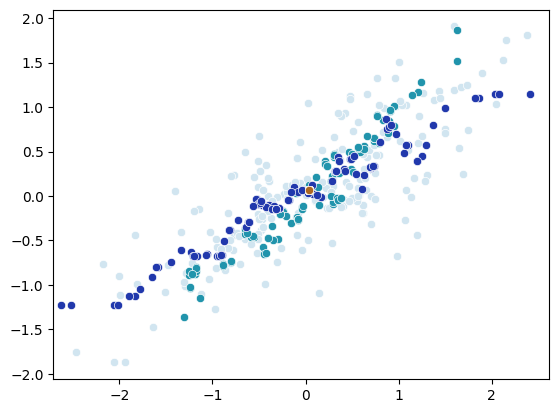

In [ ]:
ax = sns.scatterplot(x=xmiss[where_full, 0], y=xmiss[where_full, 1], color=['#d1e5f0'])

(xmin, xmax), (ymin, ymax) = ax.get_xlim(), ax.get_ylim()

_ = sns.scatterplot(x=ximp_knn[where_na0, 0], y=ximp_knn[where_na0, 1], color=['#2194ac'], ax=ax, clip_on=False)
_ = sns.scatterplot(x=ximp_knn[where_na1, 0], y=ximp_knn[where_na1, 1], color=['#2138ac'], ax=ax, clip_on=False)
_ = sns.scatterplot(x=ximp_knn[where_na01, 0], y=ximp_knn[where_na01, 1], color=['#ac6721'], ax=ax, clip_on=False)

ax.set_xlim(xmin, xmax);
ax.set_ylim(ymin, ymax);

## Question 7 : random forests

Another important example of non-parametric imputation is iterative imputation with random forests — or other decision tree–based models. Use `IterativeImputer` again to impute the dataset, this time with a Random Forest as the base estimator. Calculate its MSE and visualize the results.

The most important hyperparameters to tune are first those of the base estimator: for the random forest, these are the number of estimators and the maximum depth of the trees. For iterative imputation, it can be useful to limit the tree depth for greater stability. In `IterativeImputer`also tune the maximum number of iterations `max_iter` and the stopping criterion `tol`.

Be careful: with large datasets and many variables, this method can be computationally expensive. You may want to adjust the hyperparameters `n_nearest_features` and `skip_complete` to reduce computation time.

Note that `IterativeImputer` is still experimental and its API may change.

### Solution

In [ ]:
imputer = IterativeImputer(estimator=RandomForestRegressor(n_estimators=10, max_depth=3), max_iter=10, tol=0.001)
ximp_rf = imputer.fit_transform(xmiss)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
print(mse(ximp_rf, xfull))

0.38745210842355887


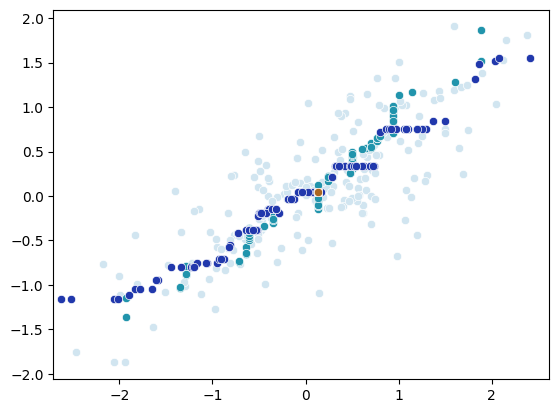

In [ ]:
ax = sns.scatterplot(x=xmiss[where_full, 0], y=xmiss[where_full, 1], color=['#d1e5f0'])

(xmin, xmax), (ymin, ymax) = ax.get_xlim(), ax.get_ylim()

_ = sns.scatterplot(x=ximp_rf[where_na0, 0], y=ximp_rf[where_na0, 1], color=['#2194ac'], ax=ax, clip_on=False)
_ = sns.scatterplot(x=ximp_rf[where_na1, 0], y=ximp_rf[where_na1, 1], color=['#2138ac'], ax=ax, clip_on=False)
_ = sns.scatterplot(x=ximp_rf[where_na01, 0], y=ximp_rf[where_na01, 1], color=['#ac6721'], ax=ax, clip_on=False)

ax.set_xlim(xmin, xmax);
ax.set_ylim(ymin, ymax);

# Exercise 2: Iterative imputation with random forests

In this exercise, you will re-implement by hand the iterative imputation algorithm, starting from the base estimator `RandomForestRegressor`. You will define a function, beginning from the following cell, which takes as input the incomplete dataset and returns the imputed dataset.

We are essentially implementing the MissForest algorithm, as described in [Steckhoven et al. (2012)](https://academic.oup.com/bioinformatics/article/28/1/112/219101) (Algorithm 1).

In [ ]:
def impute_manualrandomforest(xmiss):
    x_imputed = ...
    return x_imputed

## Question 1

In the function `impute_manualrandomforest`, create a boolean variable `mask` indicating where the missing values are in `xmiss`.

Then, determine the order of the columns of `xmiss` by increasing missing value rate and save the result in a variable `order` (here there are only 2 columns, but you will implement the general algorithm).

### Solution

In [ ]:
def impute_manualrandomforest(xmiss):
    mask = np.isnan(xmiss)
    # get order of columns by increasing number of nans
    order = np.argsort(np.isnan(xmiss).sum(axis=0))

    x_imputed = ...
    return x_imputed

## Question 2

The initialization of the algorithm is a simple imputation by the mean. In the function, use `SimpleImputer` to impute `xmiss` with its means, saving the result in the variable `x_imputed`. Test the function.

### Solution

In [ ]:
def impute_manualrandomforest(xmiss):
    mask = np.isnan(xmiss)
    # get order of columns by increasing number of nans
    order = np.argsort(np.isnan(xmiss).sum(axis=0))

    # impute the array by its means
    mean_imputer = SimpleImputer(strategy='mean')
    x_imputed = mean_imputer.fit_transform(xmiss)

    return x_imputed

In [ ]:
ximp_manrf = impute_manualrandomforest(xmiss)
print(mse(ximp_manrf, xfull))

0.5681994027699139


## Question 3

Using the order established in question 1, select the column with the fewest missing values, `col`.

Using only the indices `i` where `xmiss[i, col]` is observed (i.e., where `mask[i, col] == 0`), train a random forest `rf` on the already imputed dataset `x_imputed` to predict `x_imputed[:, col]` from all the other variables.

Then use `rf` to predict the missing values of `xmiss[i, col]`. These new predictions replace the initial naive imputation in `x_imputed`.

Hint: here there are only 2 columns. To train the forest with a single feature, the following function may be helpful.

In [ ]:
def ensure_2d_column(x):
    x = np.asarray(x)
    if x.ndim == 1:
        return x.reshape(-1, 1)  # (N,) → (N, 1)
    return x

### Solution

In [ ]:
def impute_manualrandomforest(xmiss):
    mask = np.isnan(xmiss)
    # get order of columns by increasing number of nans
    order = np.argsort(np.isnan(xmiss).sum(axis=0))

    # impute the array by its means
    mean_imputer = SimpleImputer(strategy='mean')
    x_imputed = mean_imputer.fit_transform(xmiss)

    # select column to impute
    col = order[0]
    other_cols = [c for c in order if c != col]

    # select indices where col is observed
    obs_indices = (mask[:, col] == 0)
    mis_indices = (mask[:, col] == 1)

    # fit random forest
    rf = RandomForestRegressor(n_estimators=10, max_depth=3)
    rf.fit(X=ensure_2d_column(x_imputed[obs_indices, other_cols]), y=x_imputed[obs_indices, col])
    # get new prediction
    pred = rf.predict(X=ensure_2d_column(x_imputed[mis_indices, other_cols]))
    # replace in array
    x_imputed[mis_indices, col] = pred

    return x_imputed

In [ ]:
ximp_manrf = impute_manualrandomforest(xmiss)
print(mse(ximp_manrf, xfull))

0.4974167021598819


## Question 4

The algorithm consists of repeating the previous step by looping over all columns, as many times as necessary until the stopping criterion is met or the maximum number of iterations is reached.

The stopping criterion is met when the difference between two successive imputations is less than a threshold. The difference function is provided above.

In [ ]:
def difference(x_new, x_old):
  return np.sum((x_new - x_old) ** 2) / np.sum(x_new ** 2)

### Solution

In [ ]:
def impute_manualrandomforest(xmiss, max_iter=10, tol=0.001):
    mask = np.isnan(xmiss)
    # get order of columns by increasing number of nans
    order = np.argsort(np.isnan(xmiss).sum(axis=0))

    # impute the array by its means
    mean_imputer = SimpleImputer(strategy='mean')
    x_imputed = mean_imputer.fit_transform(xmiss)

    # no more than max_iter loops
    for iteration in range(max_iter):
        # loop over columns to impute
        for col in order:
            # save a copy to measure the difference between 2 successive imputations
            x_imputed_old = np.copy(x_imputed)

            other_cols = [c for c in order if c != col]

            # select indices where col is observed
            obs_indices = (mask[:, col] == 0)
            mis_indices = (mask[:, col] == 1)

            # fit random forest
            rf = RandomForestRegressor(n_estimators=10, max_depth=3)
            rf.fit(X=ensure_2d_column(x_imputed[obs_indices, other_cols]), y=x_imputed[obs_indices, col])
            # get new prediction
            pred = rf.predict(X=ensure_2d_column(x_imputed[mis_indices, other_cols]))
            # replace in array
            x_imputed[mis_indices, col] = pred

            diff = difference(x_imputed, x_imputed_old)
            if diff < tol:
                return x_imputed

    warnings.warn("max_iter was reached.")
    return x_imputed

In [ ]:
ximp_manrf = impute_manualrandomforest(xmiss)
print(mse(ximp_manrf, xfull))

0.38713737695094663


# Exercise 3: Comparison of imputation methods on a real dataset

In this exercise, you consider the same complete real dataset *Breast Cancer Wisconsin* as in Notebook 1 (Exercise 4). We generate 30% missing values of the MCAR type.

In [ ]:
data = load_breast_cancer()
xfull = data['data']  # covariates, without missing values
diagnosis = data['target']  # target variable to predict, when the learning task is prediction
features_names = data['feature_names']

In [ ]:
pd.DataFrame(xfull, columns=features_names).head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
n, d = xfull.shape  # data dimension

In [ ]:
np.random.seed(123)

p = 0.3
xmiss = np.copy(xfull)
for j in range(d):
  miss_id = np.random.uniform(0, 1, size=n) < p
  xmiss[miss_id, j] = np.nan

## Question 1

Apply the imputation methods from Exercise 1 to this dataset, optimizing the hyperparameters :
* mean imputation
* k-nearest neighbors imputation
* iterative imputation based on linear regression
* iterative imputation based on random forest

Compare their MSEs: which method performs best on this dataset?

### Solution

In [ ]:
def evaluate_imputer(imputer, xfull, xmiss):
    ximp = imputer.fit_transform(xmiss)
    score = mse(ximp, xfull)
    print(f"{imputer.__str__():<60}: MSE = {score:.6f}")
    return score

def compare_imputers(xfull, xmiss):
    results = {}

    # 1. SimpleImputer (mean)
    simple = SimpleImputer(strategy='mean')
    score = evaluate_imputer(simple, xfull, xmiss)
    results['SimpleImputer (mean)'] = score

    # 2. KNNImputer (optimize k)
    for k in [3, 5, 10, 15]:
        knn = KNNImputer(n_neighbors=k)
        score = evaluate_imputer(knn, xfull, xmiss)
        results[f'KNNImputer (best_k={k})'] = score

    # 3. IterativeImputer + LinearRegression (optimize tol)
    for tol in [0.1, 0.01, 0.001, 0.0001]:
        iter_lr = IterativeImputer(estimator=LinearRegression(), tol=tol)
        score = evaluate_imputer(iter_lr, xfull, xmiss)
        results[f'IterativeImputer + LR (tol={tol})'] = score

    # 4. IterativeImputer + RandomForestRegressor (optimize depth, tol)
    param_grid = ParameterGrid({
        'max_depth': [3, 5, 7],
        'tol': [0.1, 0.01]
    })
    for params in param_grid:
        rf = RandomForestRegressor(n_estimators=10, max_depth=params['max_depth'], random_state=0)
        iter_rf = IterativeImputer(estimator=rf, max_iter=10, tol=params['tol'])
        score = evaluate_imputer(iter_rf, xfull, xmiss)
        key = f"IterativeImputer + RF (depth={params['max_depth']}, tol={params['tol']})"
        results[key] = score

    return results

In [ ]:
results = compare_imputers(xfull, xmiss)

SimpleImputer()                                             : MSE = 136619.020273
KNNImputer(n_neighbors=3)                                   : MSE = 71418.981485
KNNImputer()                                                : MSE = 66996.201756
KNNImputer(n_neighbors=10)                                  : MSE = 58569.749929
KNNImputer(n_neighbors=15)                                  : MSE = 56487.583285
IterativeImputer(estimator=LinearRegression(), tol=0.1)     : MSE = 3359.526592
IterativeImputer(estimator=LinearRegression(), tol=0.01)    : MSE = 3359.509858
IterativeImputer(estimator=LinearRegression())              : MSE = 3359.509858
IterativeImputer(estimator=LinearRegression(), tol=0.0001)  : MSE = 3359.510129
IterativeImputer(estimator=RandomForestRegressor(max_depth=3, n_estimators=10,
                                                 random_state=0),
                 tol=0.1): MSE = 4759.433432


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


IterativeImputer(estimator=RandomForestRegressor(max_depth=3, n_estimators=10,
                                                 random_state=0),
                 tol=0.01): MSE = 5395.008355
IterativeImputer(estimator=RandomForestRegressor(max_depth=5, n_estimators=10,
                                                 random_state=0),
                 tol=0.1): MSE = 3698.222448


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


IterativeImputer(estimator=RandomForestRegressor(max_depth=5, n_estimators=10,
                                                 random_state=0),
                 tol=0.01): MSE = 3920.220407
IterativeImputer(estimator=RandomForestRegressor(max_depth=7, n_estimators=10,
                                                 random_state=0),
                 tol=0.1): MSE = 4104.307527
IterativeImputer(estimator=RandomForestRegressor(max_depth=7, n_estimators=10,
                                                 random_state=0),
                 tol=0.01): MSE = 3887.371495


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
for name, score in sorted(results.items(), key=lambda x: x[1]):
    print(f"{name:<45}: MSE = {score:.6f}")

IterativeImputer + LR (tol=0.01)             : MSE = 3359.509858
IterativeImputer + LR (tol=0.001)            : MSE = 3359.509858
IterativeImputer + LR (tol=0.0001)           : MSE = 3359.510129
IterativeImputer + LR (tol=0.1)              : MSE = 3359.526592
IterativeImputer + RF (depth=5, tol=0.1)     : MSE = 3698.222448
IterativeImputer + RF (depth=7, tol=0.01)    : MSE = 3887.371495
IterativeImputer + RF (depth=5, tol=0.01)    : MSE = 3920.220407
IterativeImputer + RF (depth=7, tol=0.1)     : MSE = 4104.307527
IterativeImputer + RF (depth=3, tol=0.1)     : MSE = 4759.433432
IterativeImputer + RF (depth=3, tol=0.01)    : MSE = 5395.008355
KNNImputer (best_k=15)                       : MSE = 56487.583285
KNNImputer (best_k=10)                       : MSE = 58569.749929
KNNImputer (best_k=5)                        : MSE = 66996.201756
KNNImputer (best_k=3)                        : MSE = 71418.981485
SimpleImputer (mean)                         : MSE = 136619.020273


Among the models tested, the best imputation is achieved by iterative imputation. The choice of the base estimator, as well as the selection of hyperparameters, does not appear to be crucial — or should instead be subjected to a more thorough model selection process.

The poor performance of $k$-nearest neighbors imputation is most likely due to the high dimensionality.